<a href="https://colab.research.google.com/github/musicjae/Hands_on_ML/blob/master/(3)_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving a1.png to a1.png
User uploaded file "a1.png" with length 64129 bytes


In [ ]:
from IPython.display import Image

# 3.1 MNIST  
  
이것은 여러 사람들이 직접 손으로 쓴 7 만 개의 작은 숫자 이미지를 모은 데이터이다. 이것의 크기는 (70,000, 784) 이고, 또한 이것은 이미Trainig set과 Test set을 6:1 로 나누어 두었다.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys() # 9 개의 keys 가 있다.

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape) # 7만 개의 이미지가 있고 784 개의 features가 있다.
print(y.shape)

(70000, 784)
(70000,)


<function matplotlib.pyplot.show>

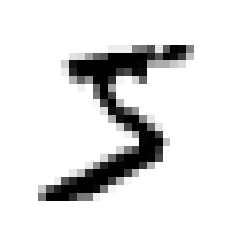

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show

In [ ]:
# 실제 레이블 확인해보자:
print(y[0], y.astype)

5 <built-in method astype of numpy.ndarray object at 0x7f446683d5d0>


In [ ]:
import numpy as np

y= y.astype(np.uint8)
print(y.astype)

<built-in method astype of numpy.ndarray object at 0x7fab3fcc1080>


## 테스트셋, 트레이닝 셋 분류

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]
print(X_train[:3])
print(y_test[:3])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[7 2 1]


MNIST에서는 이미 훈련 세트가 섞여 있다. 따라서 모든 교차 검증 폴드를 비슷하게 만든다.  
  
- Training set을 섞는 이유: 어떤 알고리즘은 훈련 샘플 순서에 민감해서, 많은 유사한 샘플이 **연이어** 나타나면 성능이 나빠진다. ==> 이것을 해결하기 위해 훈련 샘플을 섞는 것이다. **반면에** 시계열 데이터를 다룰 때에는 섞는 것은 좋지 않다.

# 3.2 Binary Classifier Training  
  
어떤 훈련 샘플에 대하여 '5임', '5가 아님' 이렇게 두 개의 클래스로만 구분해주는 분류기

In [ ]:
## 실험을 위해 타깃 벡터를 만들어 보자. 아래에서 만들 학습된 모델은 이 타깃 벡터를 가지고서 평가될 것이다.

y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

print(y_train_5[0:3])
print(y_test_5[0:3])

[ True False False]
[False False False]


여기서 SGD를 사용해보자. [장점] 이것은 **큰** **데이터셋을** 효율적으로 처리하게 해준다. 왜냐하면 이것은 1 iter 당 1 개의 샘플을 **독립적으로** 처리한다.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # 무작위성 사용 --> 확률적
sgd_clf.fit(X_train, y_train_5)

# SGD는 훈련하는 데 randomness를 사용한다. 그래서 '확률적'이라는 이름이 붙은 것이다.

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit]) # some_digit = X[0] 임을 기억하라. 그러면 아래가 참인 것을 받아들일 수 있을 것이다.

array([ True])

# 3.3 성능 측정 (분류기 평가)

### [1] 교차 검증  
  
폴드가 3 개인 k겹 교차 검증을 사용하여 SGDClassifier 모델을 평가해보자.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # 원본을 상하게 하지 않기 위해 도입
import time

skfolds = StratifiedKFold(n_splits=3, random_state=42) # 클래스 별 비율이 유지되도록 폴드를 만들게 하기 위해, Stratified Sampling 사용
start = time.time()
for train_idx, test_idx in skfolds.split(X_train, y_train_5): # 훈련 시 사용할 샘플들과, 훈련 시 사용할 y==5를 만족하는 참 레이블 샘플로 split

    clone_clf = clone(sgd_clf) # 위에서 만든 sgd분류기 복사

    X_train_folds = X_train[train_idx] # 훈련 idx가 순회하면서 X 훈련 샘플을 각 fold에 저장
    y_train_folds = y_train_5[train_idx] # 동일

    X_test_fold = X_train[test_idx] # 테스트 idx가 순회하면서 X 훈련 샘플을 각 fold에 저장
    y_test_fold = y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds) # 복제한 분류기를 위에서 만든 folds를 이용하여 fitting 해준다.
    y_pred = clone_clf.predict(X_test_fold) # 예측값은 X_test_fold 가지고 구한다.
    n_correct = sum(y_pred == y_test_fold) # 양측이 일치할 때에만 더해준다.
    
    print(n_correct/len(y_pred)*100,'%') # 정답 비율 구하기
end=time.time()

print(end-start,'sec')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


95.035 %
96.035 %
96.04 %
32.95583486557007 sec


In [ ]:
# 교차 검증 함수 사용

from sklearn.model_selection import cross_val_score
import time

start=time.time()
a=cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

for i in range(3):

    print(a[i]*100,'%')

end=time.time()
print(end-start,'sec')


95.035 %
96.035 %
96.04 %
31.620858430862427 sec


-  함수 사용 여부는 소요 시간 측면에서 큰 차이는 없는 것 같다.
  
- 하지만 불균형한 데이터셋을 다룰 때 특히 이 **정확도**은 분류기의 성능 측정 지표로 선호되지 않는다.

## [2] 오차 행렬 confusion matrix  
  
Basic idea:  
  
Count:   
  
sample 'a' in the Class A ----classify----> Class B  
  
Otherwise:  
  
No count

cross_val_predict는 k겹 교차검증 수행 but 이것은 __score와는 다르게 (평가 점수 반환 x) 단지 각 테스트 폴드에서 얻은 예측만을 반환.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3) 

In [ ]:
print(y_train_pred[:3])

[ True False False]


위 처럼 score가 아닌 predict를 사용하면 한 번도 정답을 보지 못한 순수히 깨끗한 예측값들만을  얻을 수 있다.  
  
이제, 오차 행렬을 만들어보자. 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

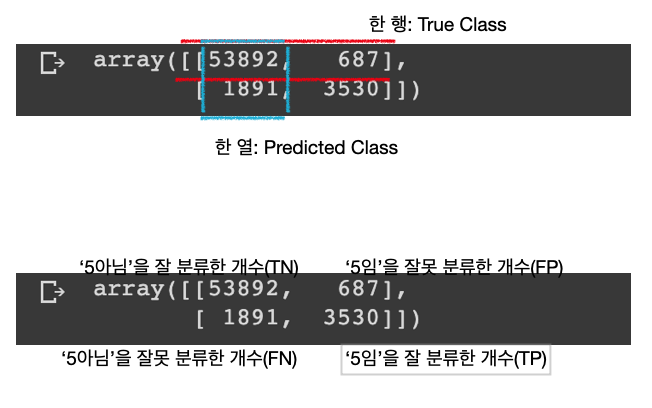

In [ ]:
Image('a1.png',width=700)

### 더 요약된 2 가지 지표들  
  
**정밀도Precision**: 양성 예측의 정확도  
  
$=\frac{TP}{TP+FP}$

한계: 정밀도는 확실한 양성 샘플 하나만 예측하면 완벽해지는데, 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 유용하지 않다. 정밀도는 보통 **재현율recall**과 함께 사용하는 것이 일반적이다.

**재현율**: 민감도, 진짜 양성 비율TPR 이라고 불린다.  
$=\frac{TP}{TP+FN}$  
  


"즉, Precision이나 Recall은 모두 실제 True인 정답을 모델이 True라고 예측한 경우에 관심이 있으나, 바라보고자 하는 관점만 다릅니다. Precision은 모델의 입장에서, 그리고 Recall은 실제 정답(data)의 입장에서 정답을 정답이라고 맞춘 경우를 바라보고 있습니다. 다음의 경우를 생각해보겠습니다.



"어떤 요소에 의해, 확실히 맑은 날을 예측할 수 있다면 해당하는 날에만 맑은 날이라고 예측하면 되겠다."


이 경우에는 확실하지 않은 날에는 아에 예측을 하지 않고 보류하여 FP의 경우의 수를 줄여, Precision을 극도로 끌어올리는 일종의 편법입니다. 예를 들어 한달 30일 동안 맑은 날이 20일이었는데, 확실한 2일만 맑다고 예측한다면, 당연히 맑다고 한 날 중에 실제 맑은 날(Precision)은 100%가 나오게 됩니다. 하지만 과연, 이러한 모델이 이상적인 모델일까요?


따라서, 우리는 실제 맑은 20일 중에서 예측한 맑은 날의 수도 고려해 보아야합니다. 이 경우에는 Precision만큼 높은 결과가 나오지 않습니다. Precision과 함께 Recall을 함께 고려하면 실제 맑은 날들(즉, 분류의 대상이 되는 정의역, 실제 data)의 입장에서 우리의 모델이 맑다고 예측한 비율을 함께 고려하게 되어 제대로 평가할 수 있습니다. Precision과 Recall은 상호보완적으로 사용할 수 있으며, 두 지표가 모두 높을 수록 좋은 모델입니다."   
  
https://sumniya.tistory.com/26

참고: 정확도 = $\frac{tp+tn}{tp+tn+fp+fn}$

# 3.3 정밀도와 재현율 Precision & Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

print('정밀도:',precision_score(y_train_5,y_train_pred))
print('재현도:',recall_score(y_train_5,y_train_pred))


정밀도: 0.8370879772350012
재현도: 0.6511713705958311


#### F1 점수: 정밀도와 재현율의 조화평균.  
  
$F_1 = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [ ]:
from sklearn.metrics import f1_score  
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷할수록 F1 점수가 높게 나온다. 하지만 이것이 항상 바람직한 것은 아니다. 경우에 따라 둘 중 하나가 더 중요할 수 있다.  
  
[그 사례]  
  
- 어린이들에게 유해 동영상을 필터링해야 하는 경우는 "좋은 동영상이 제외되더라도" "나쁜 동영상을 제외한, 안전한 동영상만을 노출"시키는 것 -- 그러면 높은 정밀도가 요구돼 -- 이 더 중요하다.  
  
- 감시 카메라로 도둑을 잡는 경우는 실제 정답을 포착하는 것이 더 중요하므로 정밀도 보다 재현율이 더 중요시될 것이다.

# 3.4 정밀도/재현율 트레이드오프  
  


SGD분류기를 이용하여 트레이드오프를 알아보자. 이 분류기는 **결정함수decision_function**을 사용하여 *각 샘플의 점수를 계산*한다.  
  
if 그 점수 > 임곗값 -> 그 샘플은 positive class에 할당  

otherwise -> 그 샘플은 negative class에 할당  
  
- 임곗값 상승 ==> 정밀도 상승 
  
- 임곗값 하락 ==> 재현율 상승 & 정밀도 하락

In [ ]:
y_scores = sgd_clf.decision_function([some_digit]) # 임곗값 확인
print(y_scores)

[2164.22030239]


In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


위 결과는 임곗값을 높이면 **재현율이_줄어든다**는 것을 보여준다. 

#### 적절한 임곗값을 정하는 방안  
  
아래 함수를 사용해보자.

- 훈련 세트에 있는 모든 점수 구하기  
   
- 예측 점수가 아닌, 결정 점수를 반환하도록 지정

In [ ]:
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_5, # 훈련 세트에 있는 모든 점수 고려
                             cv=3,
                             method="decision_function")  # 결정 점수 반환

In [ ]:
print(y_scores[0:3], y_train_5[0:3])

[  1200.93051237 -26883.79202424 -33072.03475406] [ True False False]


In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) # 예측값과 참값으로 예측 재현율 곡선 만듦

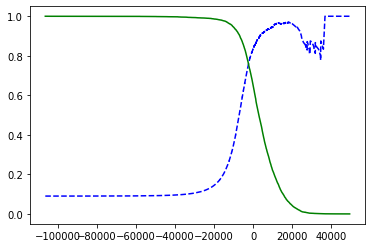

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_precision_recall_VS_threshold(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds,recalls[:-1],"g-",label="재현율")

plot_precision_recall_VS_threshold(precisions,recalls,thresholds)
plt.show()

정밀도가 파란선, 재현율이 초록선이다. 위 그림에서 보는 바와 같이, 정밀도가 재현율보다 더 굴곡지다. 그 이유는 임곗값을 올리더라도 정밀도가 종종 낮아질 때가 있기 때문이다. (* 그 사례는 본서 p.137의 그림 3-3을 보면 이해할 수 있다.)

#### 좋은 정밀도/재현율 트레이드오프 곡선을 선택하는 방법  
  
재현율 곡선에서 급강하 하는 지점의 직전을 정밀도/재현율의 트레이드오프로 선택하는 것이 좋다. 아래 그림에 따른다면, 0.6 정도가 적당할 것 같다.

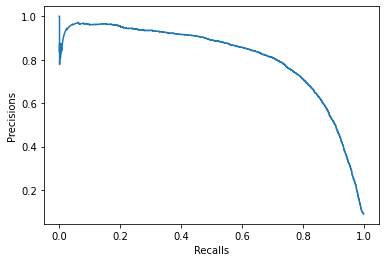

In [ ]:
plt.plot(recalls[:-1],precisions[:-1])
plt.xlabel('Recalls')
plt.ylabel('Precisions')
plt.show()

# 3.5 ROC 곡선  
  
- ROC receiver operating characteristic 곡선도 **이진_분류**에서 널리 사용되는 도구다. 이것은 FPR (False Positive Rate)에 대한 TPR(재현율 True Positive Rate)의 곡선이다.   
  
- 더욱이, 이것은 1에서 TNR(True Negative Rate)를 뺀 값이기도 하다.  
    

$$FPR=\frac{FP}{FP+TN}=\frac{FP+TN-TN}{FP+TN}=1-\frac{TN}{FP+TN}=1-TNR$$

[생각해보기]  
  
그러니까 ROC는 참인 것을 잘못 찾아내는 것에 대한 비율FPR에 대해 참인 것을 제대로 찾아내는 재현율에 대한 곡선이라는 것이네.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

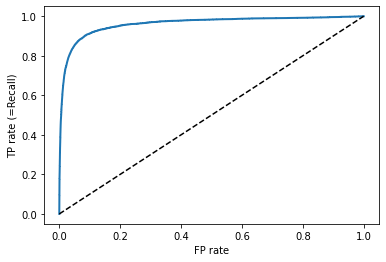

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):

    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1],'k--') # 대각 점선
    plt.xlabel('FP rate')
    plt.ylabel('TP rate (=Recall)')

plot_roc_curve(fpr,tpr)
plt.show()

- 위 그래프를 참고할 때, TPR(Recall)이 높을수록, 분류기가 만드는 FPR이 늘어난다.  
  
- 점선은 **Perfect_Random_Classifier**의 ROC 곡선을 뜻한다. 좋은 분류기는 이 점선에서 가능한 한 멀리 떨어져 있어야 한다.

##### 어떻게 분류기들을 비교할 것인가?  

AUC (Area Under the Curve)를 측정하면 여러 분류기들을 비교할 수 있다.   
- Perfect Classifier는 ROC의 AUC = 1  
  
- Perfect Random Classifier는 AUC = 0.5   
  
(PRC는 훈련 data의 클래스 비율을 따라 randomly 예측하는 것을 뜻한다. 이것은 오차 행렬의 실제 class가 예측 class를 비슷한 비율로 나누기 때문에 FPR과 TPR이 비슷해진다. 그래서 결국 y=x 곡선에 가깝게 되어 AUC 면적이 0.5가 된다.)

In [ ]:
from sklearn.metrics import roc_auc_score  

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### 언제 어떤 곡선을 사용할 것인가?  
  
- (Positive Class가 드물다) V (FP more important than FN) ==> PR 곡선 사용  
> PR 곡선은 "분류기 성능 개선 여지"를 보여준다.  
  
- Otherwise ==> ROC 곡선 사용  
    
  


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) # 이 포레스트clf 훈련시켜서, SGD의 ROC AUC 점수 비교해보자.
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # predict_proba() 메서드는 sample이 행, class가 열이고, <sample이 주어진 class에 속할 확률>을 담은 배열 리턴

위의 y_probas_forest는 X_train이 y_train_5에 속할 확률을 반환하는 것 같다.

In [ ]:
print(y_probas_forest.size,y_probas_forest.shape)


120000 (60000, 2)


Roc_curve 는 레이블과 점수를 기대한다. 하지만 점수 대신 클래스 확률을 전달할 수 있다. 아래에서 Positive Class를 점수로 사용해보자.

In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest,thresholds_forest = roc_curve(y_train_5, y_scores_forest)

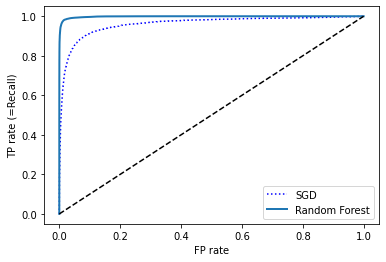

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

전술했듯이, 왼쪽 모서리 위에 있을수록, 즉 점선 보다 더 떨어져 있을수록 좋은 분류기라고 간주된다. 그러면, 위 그림을 참고할 때, Random Forest는 SGD 보다 더 좋은 분류기라고 판단될 수 있다.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest) # 정밀도 점수


0.9983436731328145

# 3.4 다중 분류 Multiclass Classifier

(1) 여러 개 클래스 직접 처리  
  
(2) 여러 개의 이진 분류기를 함께 사용  
  
- 2.1) 특정 숫자 하나만 구분하는 이진 분류기 10 개 함께 사용  

>1 - 10까지 그것의 참 여부를 분류 --> 각 분류기의 결정 점수 중 the highest를 클래스로 선택. 이를 OvR (One versus the Rest)이라 함.
  
- 2.2) 0과1 구별, 1과2구별, ... 각 숫자의 조합마다 이진 분류기 훈련  

> 이를 OvO 이라고 한다. 클래스가 N 개이면, 분류기는 $\frac{N(N-1)}{2}$이다. 이 OvO (One - One) 전략의 **장점**은 각 분류기의 훈련에서, 전체 훈련 셋 중 구별할 2 class에 해당하는 샘플만 필요하다는 점이다. [효율적]

##### 언제 무엇을 사용해야 하는가?  
  
- OvO 선호: SVM 알고리즘 같이 **훈련셋의_크기에_민감한** 것은 큰 훈련 셋에서 몇 개의 분류기를 훈련시키는 것 보다 작은 훈련 셋에서 많은 분류기를 훈련시키는 게 더 효율적이어서, OvO 선호.  
  
- OvR 선호: 대부분의 이진 알고리즘에서는 OvR 선호

### SVM 분류기 테스트

In [ ]:
from sklearn.svm import SVC  
import time

start=time.time()
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit]) # X[0]
end=time.time()

print('time: ',end-start,'sec')

NameError: ignored

위 코드 진행 과정 동안에, 내부에서는 OvO 전략을 사용하여 10 개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어서, 그들 중 가장 높은 점수를 얻는 Class를 선택한다.

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

References  
  
[1] 오렐리앙 제롱, "핸즈온 머신러닝" 2판  

[2] https://sumniya.tistory.com/26